In [86]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdMolAlign import *
from rdkit.Chem.rdForceFieldHelpers import *

In [87]:
# This is the rdkit ConstrainedEmbed function from AllChem
# Have edited to make it a bit shorter by deleting the instructions 
def MultiConstrainedEmbed(mol,core,useTethers=True,coreConfId=-1,
                          randomseed=2342):
    
    # In original constrained function, only a single match was found.
    # Here we look for multiple matches
    matches = mol.GetSubstructMatches(core)
    if not matches:
        raise ValueError("molecule doesn't match the core")
    
    mols = []
    
    # Let's do exactly what the original function did but loop
    # over our matches 
    for match in matches:
        
        coordMap={}
        coreConf = core.GetConformer(coreConfId)
        
        for i,idxI in enumerate(match):
            corePtI = coreConf.GetAtomPosition(i)
            coordMap[idxI]=corePtI
        
        ci = AllChem.EmbedMolecule(mol,coordMap=coordMap,randomSeed=randomseed)
        
        if ci<0:
            raise ValueError('Could not embed molecule.')
        
        algMap=[(j,i) for i,j in enumerate(match)]
        
        if not useTethers:
            # clean up the conformation
            ff = UFFGetMoleculeForceField(mol,confId=0)
            for i,idxI in enumerate(match):
                for j in range(i+1,len(match)):
                    idxJ = match[j]
                    d = coordMap[idxI].Distance(coordMap[idxJ])
                    ff.AddDistanceConstraint(idxI,idxJ,d,d,100.)
            ff.Initialize()
            n=4          
            more=ff.Minimize()
            while more and n:
                more=ff.Minimize()
                n-=1
            # rotate the embedded conformation onto the core:
            rms =AlignMol(mol,core,atomMap=algMap)
        else:
            # rotate the embedded conformation onto the core:
            rms = AlignMol(mol,core,atomMap=algMap)
            ff =  UFFGetMoleculeForceField(mol,confId=0)
            conf = core.GetConformer()
            for i in range(core.GetNumAtoms()):
                p =conf.GetAtomPosition(i)
                pIdx=ff.AddExtraPoint(p.x,p.y,p.z,fixed=True)-1
                ff.AddDistanceConstraint(pIdx,match[i],0,0,100.)
            ff.Initialize()
            n=4
            more=ff.Minimize(energyTol=1e-4,forceTol=1e-3)
            while more and n:
                more=ff.Minimize(energyTol=1e-4,forceTol=1e-3)
                n-=1
            # realign
            rms = AlignMol(mol,core,atomMap=algMap)
    
        mol.SetProp('EmbedRMS',str(rms))
        mols.append(mol)
    
    # Return a list of mols
    return mols

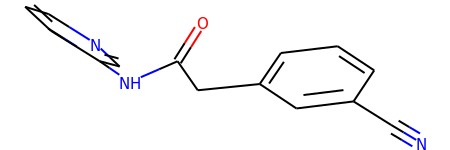

In [13]:
# Lets play around with substructure matching first
mol_1 = Chem.MolFromMolFile("data/compounds/x2600.mol")
mol_1

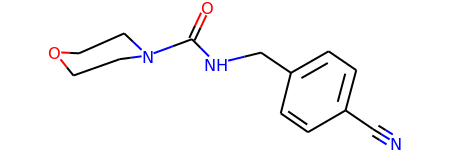

In [97]:
frag_mol = Chem.MolFromMolFile("data/frag_mols/x1249.mol")
frag_mol

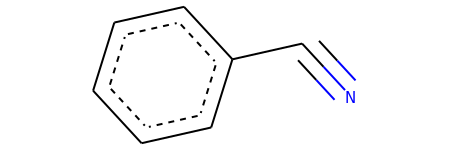

In [28]:
# Let's get a core that passes MCS between frag and designed mol
mcs = rdFMCS.FindMCS([frag_mol, mol_1], completeRingsOnly=True, matchValences=True)
patt = Chem.MolFromSmarts(mcs.smartsString,mergeHs=True)
patt

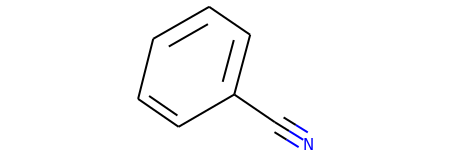

In [29]:
# Let's sort out the core 
replaced = AllChem.ReplaceSidechains(frag_mol, patt)
core = AllChem.DeleteSubstructs(replaced, Chem.MolFromSmiles('*'))
core.UpdatePropertyCache()
core

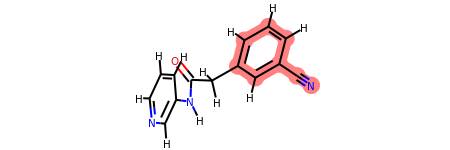

In [92]:
# Lets' look at substructure output
# First add H's to compound mol
mol_1 = Chem.AddHs(mol_1)
test = MultiConstrainedEmbed(mol_1, core)
test[0]

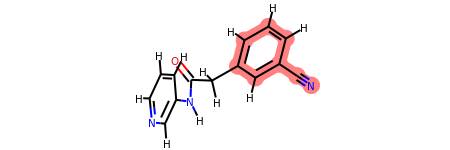

In [96]:
# Ok but is this what we'd expect if we used the original 
# constrainedembed function?
test_orig_func = AllChem.ConstrainedEmbed(mol_1, core)
test_orig_func